# Recurrent Neural Networks RNN 
## by Vesna Pop-Dimitrijoska
---

**SimpleRNN, LSTM, and GRU - MULTIVARIATE models**

**Datasets:**     
1. `Google_Stock_Price_Train.csv`  
2. `Google_Stock_Price_Test.csv`

**Task:**
1. Forecasting Google Stock Price with a SimpleRNN, LSTM and GRU univariate models for the target column 'Open'.
2. Forecasting Google Stock Price with a SimpleRNN, LSTM and GRU multivariate models for the target "Open", by using "Low", "High", and "Open" as features. (given t, predict t+1)

---
## Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Read the Dataset

In [2]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv', parse_dates=['Date'], index_col=0).sort_index()
df_test = pd.read_csv('Google_Stock_Price_Test.csv', parse_dates=['Date'], index_col=0).sort_index()

In [3]:
X_train = df_train[['High', 'Low', 'Open', 'Open']]
X_test = df_test[['High', 'Low', 'Open', 'Open']]

## Preliminary analysis of a dataset:

Shape of X_train: (1258, 4)
Shape of X_test: (20, 4)


,High,Low,Open,Open
Date,,,,
2012-01-03,332.83,324.97,325.25,325.25
2012-01-04,333.87,329.08,331.27,331.27
2012-01-05,330.75,326.89,329.83,329.83
2012-01-06,328.77,323.68,328.34,328.34
2012-01-09,322.29,309.46,322.04,322.04


,High,Low,Open,Open
Date,,,,
2017-01-03,789.63,775.80,778.81,778.81
2017-01-04,791.34,783.16,788.36,788.36
2017-01-05,794.48,785.02,786.08,786.08
2017-01-06,807.90,792.20,795.26,795.26
2017-01-09,809.97,802.83,806.40,806.40


,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


,Open,High,Low,Close
count,20.000000,20.000000,20.000000,20.000000
mean,807.526000,811.926500,801.949500,807.904500
std,15.125428,14.381198,13.278607,13.210088
min,778.810000,789.630000,775.800000,786.140000
25%,802.965000,806.735000,797.427500,802.282500
50%,806.995000,808.640000,801.530000,806.110000
75%,809.560000,817.097500,804.477500,810.760000
max,837.810000,841.950000,827.010000,835.670000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     object 
dtypes: float64(4), object(1)
memory usage: 960.0+ bytes


None

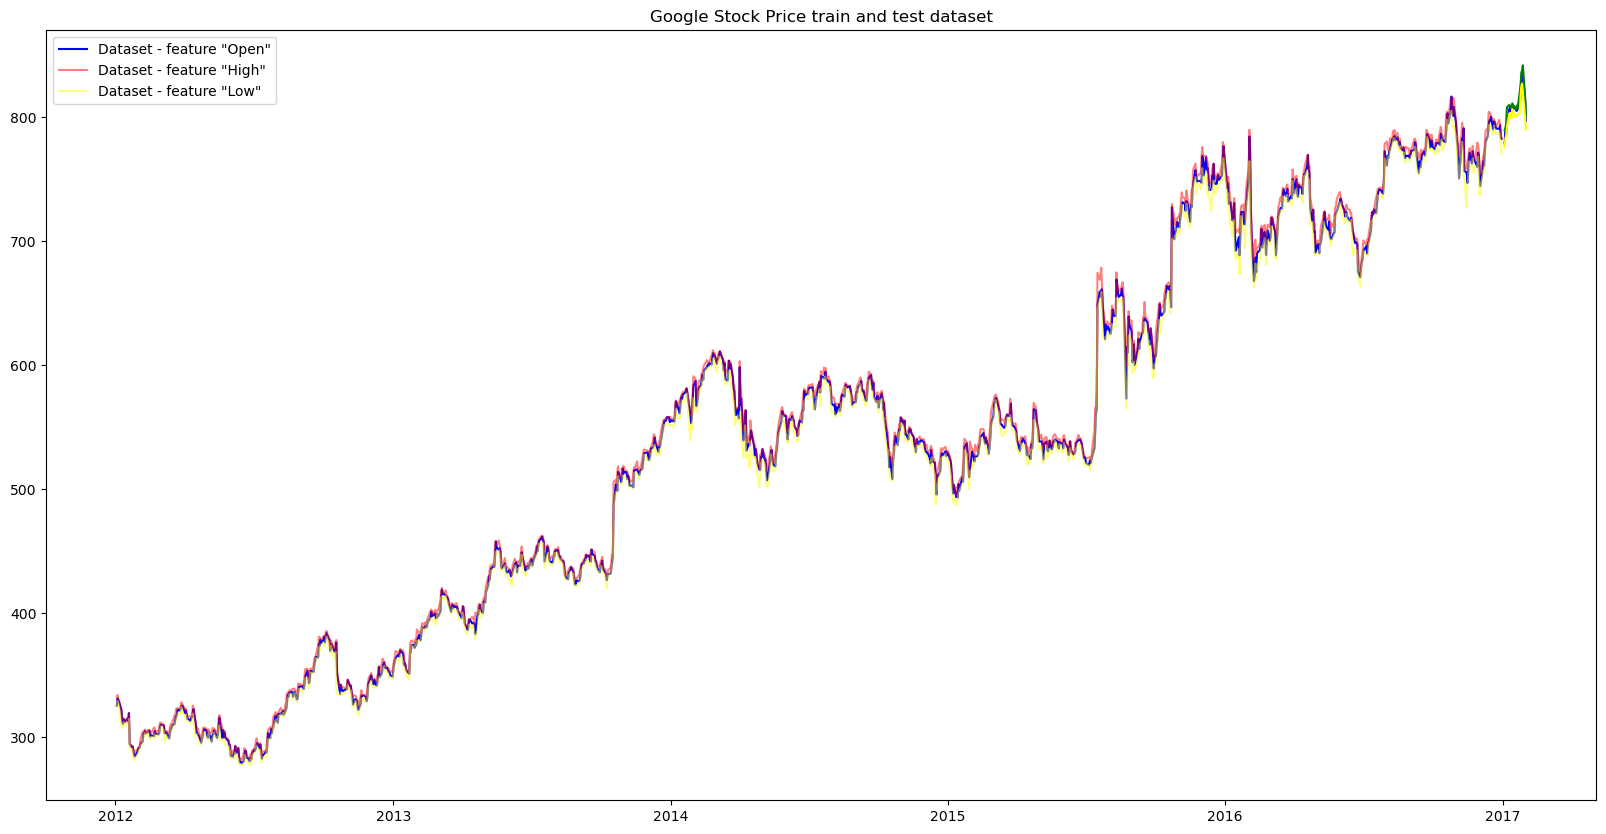

In [4]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

display(X_train.head())
display(X_test.head())

display(df_train.describe())
display(df_test.describe())

display(df_train.info())
display(df_test.info())

plt.figure(figsize=[20,10])
plt.plot(df_train[['Open']], color='blue', label='Dataset - feature "Open"')
plt.plot(df_train[['High']], color='red', alpha=0.5, label='Dataset - feature "High"')
plt.plot(df_train[['Low']], color='yellow', alpha=0.5, label='Dataset - feature "Low"')
plt.plot(df_test[['Open']], color='blue')
plt.plot(df_test[['High']], color='green')
plt.plot(df_test[['Low']], color='yellow')
plt.title('Google Stock Price train and test dataset')
plt.legend()
plt.show()

In [5]:
X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)

---
# Preliminary analysis of a dataset:
---
### Shape of a Dataset:     
Shape of the Train dataset is: 1258 rows x 3 columns (without index column - Date column).     
Shape of the Test dataset is: 20 rows x 3 columns (without index column - Date column).

### NaN values:  
There are no NaN values. 

### Data types:  
Data types are correct but they are converted in more efficient data type with smaller precision.  

### Descriptive statistics:
The summary statistics is showing that data are on a similar scale, but should be scaled in order to be easily computed. 

#

---
# Recurrent Neural Networks RNN - Regression model


## Scaling

In [6]:
train_scaler =  MinMaxScaler()
test_scaler =  MinMaxScaler()

train_scl = train_scaler.fit_transform(X_train)
test_scl = test_scaler.fit_transform(X_test)

## Creating sequences for Many-to-One - Multivariate model

In [7]:
def split_multi(sequences, n_steps):
    X, Y = [], []
    for i in range(len(sequences) - n_steps):
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break
            
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        Y.append(seq_y)
        
    return np.array(X), np.array(Y)

In [8]:
n_features = 3
n_steps = 1    # 1, 3, 7

X_train, Y_train = split_multi(train_scl, n_steps=n_steps)
X_test, Y_test = split_multi(test_scl, n_steps=n_steps)

In [9]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1257, 1, 3) (1257,)
(19, 1, 3) (19,)


---
# 1) SimpleRNN model

## Model definition

In [10]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape= (n_steps, n_features), return_sequences=True))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 100)            10400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 21021 (82.11 KB)
Trainable params: 21021 (82.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [11]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [12]:
es_cbk = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    X_train,
    Y_train,
    batch_size=1,
    epochs=100,
    callbacks=[es_cbk]
)

Epoch 1/100
1257/1257 [==============================] - 3s 1ms/step - loss: 0.0242 - mae: 0.0242
Epoch 2/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0192 - mae: 0.0192
Epoch 3/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0189 - mae: 0.0189
Epoch 4/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0181 - mae: 0.0181
Epoch 5/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0158 - mae: 0.0158
Epoch 6/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0160 - mae: 0.0160
Epoch 7/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0136 - mae: 0.0136
Epoch 8/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0150 - mae: 0.0150
Epoch 9/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0143 - mae: 0.0143
Epoch 10/100
1257/1257 [==============================] - 2s 1ms/step - loss: 0.0144 - mae: 0.0144
Epoch 11/100
1257/1

## Model prediction 

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


## Model evaluation

In [14]:
print('Preformance metrics for SimpleRNN Multivariate Model:')
print('----------------------------------------------')
print("R2 Train:", round(r2_score(Y_train, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(Y_test, test_predict)*100, 2),'%')

Preformance metrics for SimpleRNN Multivariate Model:
----------------------------------------------
R2 Train: 99.56 %
R2 Test:  71.64 %


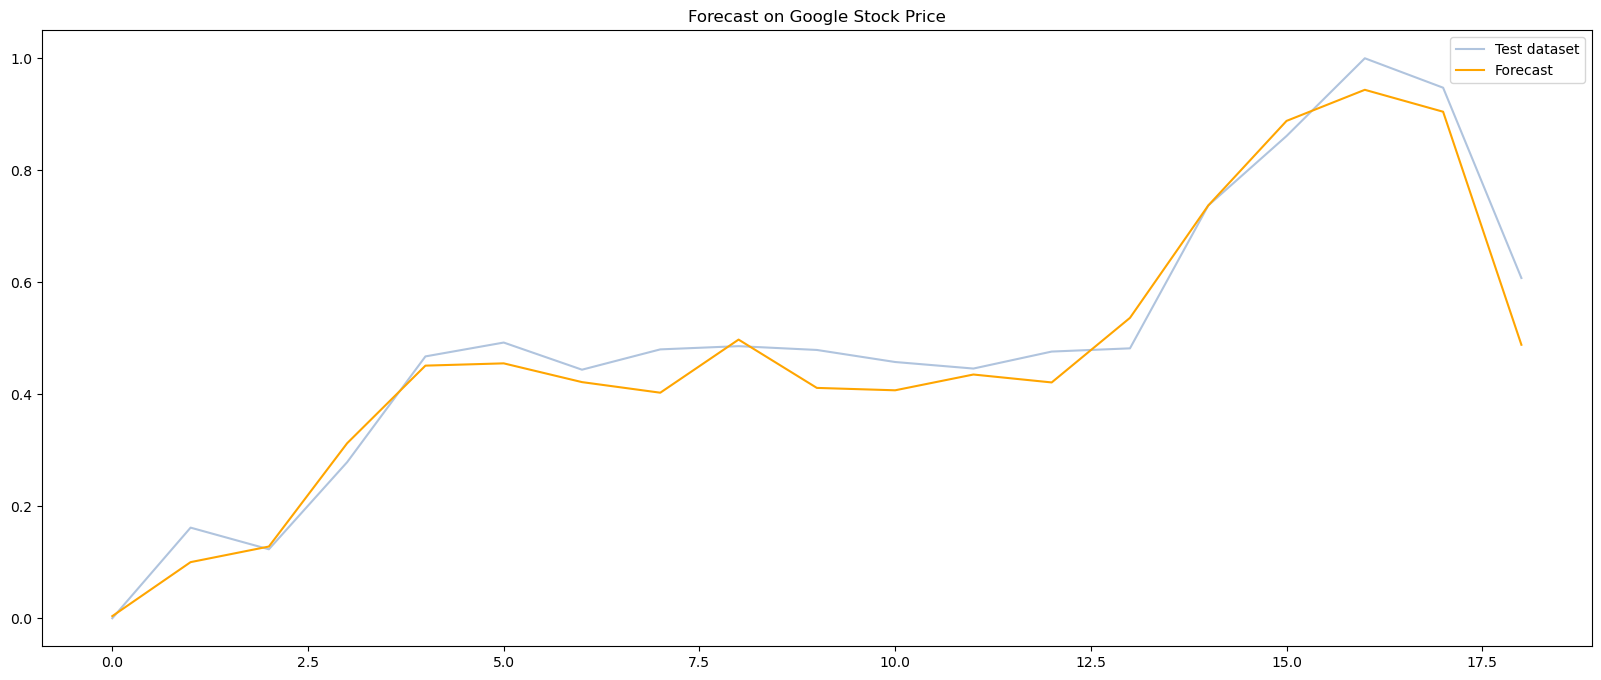

In [15]:
plt.figure(figsize=[20,8])
plt.plot(X_test[:, :, 2], color='lightsteelblue', label='Test dataset')
plt.plot(test_predict, color='orange', label='Forecast')
plt.title('Forecast on Google Stock Price')
plt.legend()
plt.show()

---
# 2) LSTM model

## Model definition

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape= (n_steps, n_features), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            41600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74871 (292.46 KB)
Trainable params: 74871 (292.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [17]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [18]:
es_cbk = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    X_train,
    Y_train,
    batch_size=1,
    epochs=100,
    callbacks=[es_cbk]
)

Epoch 1/100
1257/1257 [==============================] - 3s 2ms/step - loss: 0.0401 - mae: 0.0401
Epoch 2/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0194 - mae: 0.0194
Epoch 3/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0181 - mae: 0.0181
Epoch 4/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0184 - mae: 0.0184
Epoch 5/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0167 - mae: 0.0167
Epoch 6/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0181 - mae: 0.0181
Epoch 7/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0159 - mae: 0.0159
Epoch 8/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0156 - mae: 0.0156
Epoch 9/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0154 - mae: 0.0154
Epoch 10/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0167 - mae: 0.0167
Epoch 11/100
1257/1

## Model prediction 

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 17ms/step


## Model evaluation

In [20]:
print('Preformance metrics for LSTM Multivariate Model:')
print('------------------------------------------------')
print("R2 Train:", round(r2_score(Y_train, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(Y_test, test_predict)*100, 2),'%')

Preformance metrics for LSTM Multivariate Model:
------------------------------------------------
R2 Train: 99.79 %
R2 Test:  71.78 %


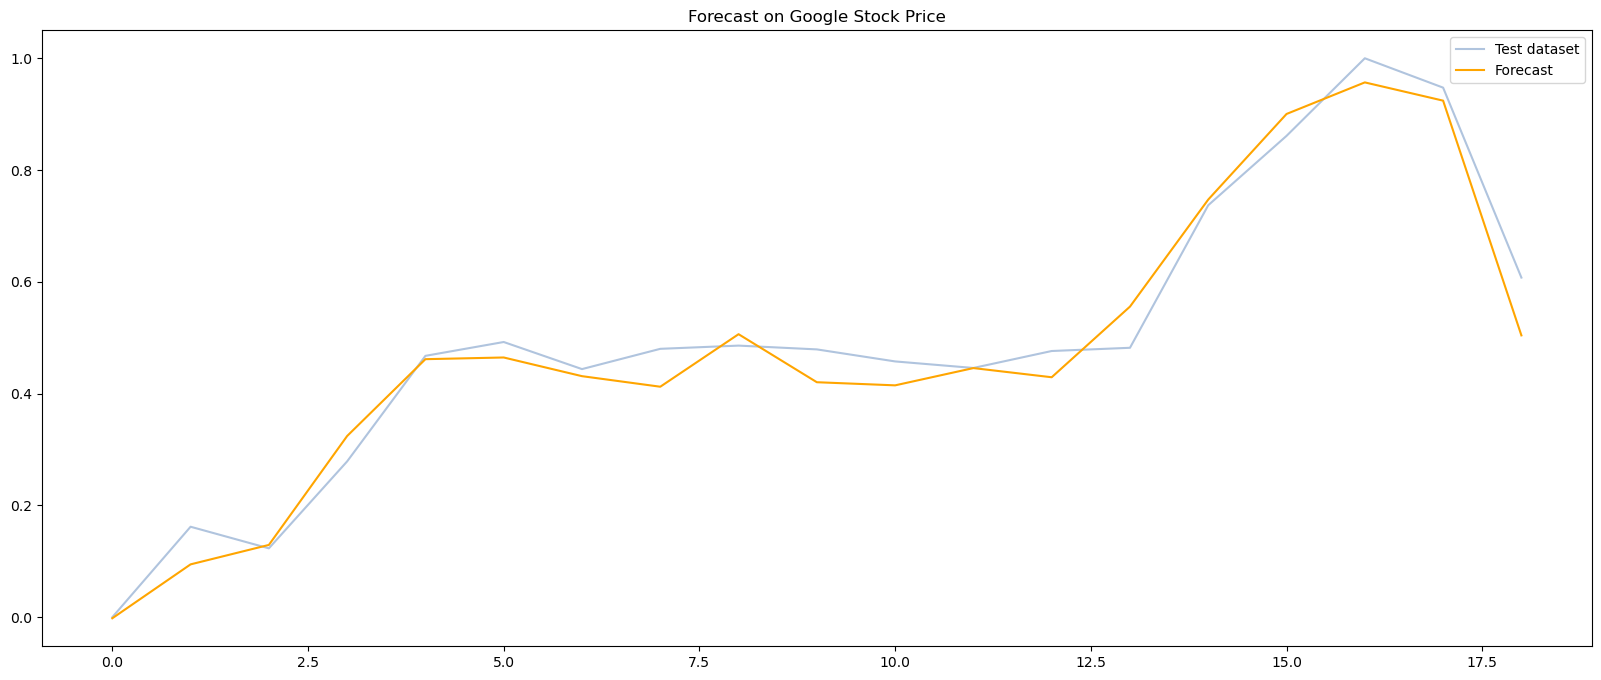

In [21]:
plt.figure(figsize=[20,8])
plt.plot(X_test[:, :, 2], color='lightsteelblue', label='Test dataset')
plt.plot(test_predict, color='orange', label='Forecast')
plt.title('Forecast on Google Stock Price')
plt.legend()
plt.show()

---
# 3) GRU model

## Model definition

In [22]:
model = Sequential()
model.add(GRU(100, activation='relu', input_shape= (n_steps, n_features), return_sequences=True))
model.add(GRU(50, activation='relu'))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            31500     
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 10)                510       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 57371 (224.11 KB)
Trainable params: 57371 (224.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Optimization process

In [23]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

## Training the model

In [24]:
es_cbk = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model_history = model.fit(
    X_train,
    Y_train,
    batch_size=1,
    epochs=100,
    callbacks=[es_cbk]
)

Epoch 1/100
1257/1257 [==============================] - 3s 2ms/step - loss: 0.0329 - mae: 0.0329
Epoch 2/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0193 - mae: 0.0193
Epoch 3/100
1257/1257 [==============================] - 3s 2ms/step - loss: 0.0175 - mae: 0.0175
Epoch 4/100
1257/1257 [==============================] - 3s 2ms/step - loss: 0.0176 - mae: 0.0176
Epoch 5/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0161 - mae: 0.0161
Epoch 6/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0164 - mae: 0.0164
Epoch 7/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0138 - mae: 0.0138
Epoch 8/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0158 - mae: 0.0158
Epoch 9/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0156 - mae: 0.0156
Epoch 10/100
1257/1257 [==============================] - 2s 2ms/step - loss: 0.0142 - mae: 0.0142
Epoch 11/100
1257/1

## Model prediction 

In [25]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


## Model evaluation

In [26]:
print('Preformance metrics for GRU Multivariate Model:')
print('-----------------------------------------------')
print("R2 Train:", round(r2_score(Y_train, train_predict)*100, 2),'%')
print("R2 Test: ", round(r2_score(Y_test, test_predict)*100, 2),'%')

Preformance metrics for GRU Multivariate Model:
-----------------------------------------------
R2 Train: 99.67 %
R2 Test:  73.17 %


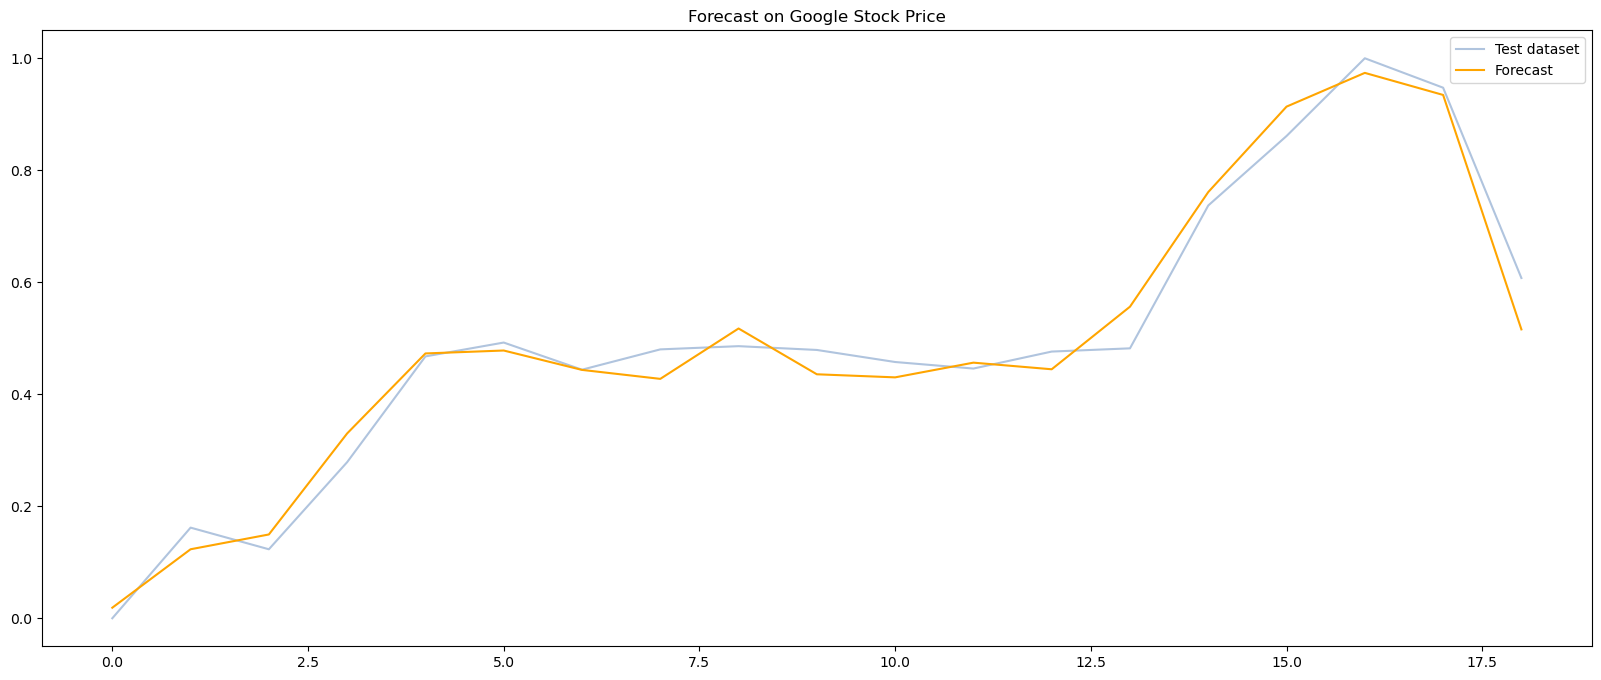

In [27]:
plt.figure(figsize=[20,8])
plt.plot(X_test[:, :, 2], color='lightsteelblue', label='Test dataset')
plt.plot(test_predict, color='orange', label='Forecast')
plt.title('Forecast on Google Stock Price')
plt.legend()
plt.show()

---
## RESULTS:
####
### 1) n_step = 1
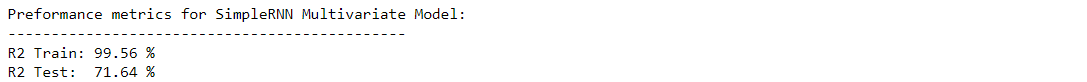
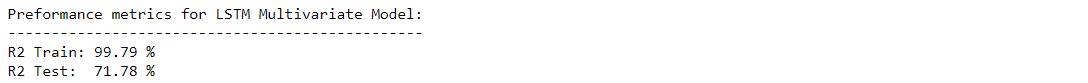
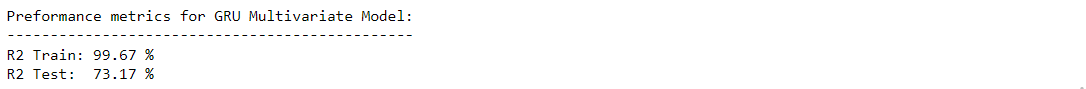

---     
####
### 2) n_step = 3
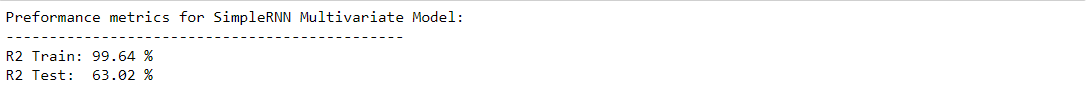
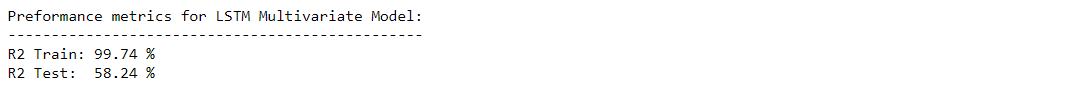
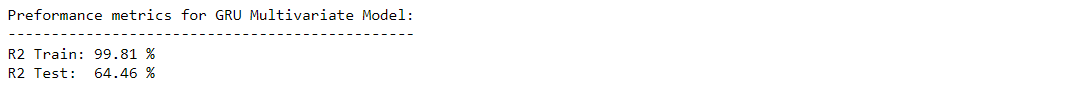

---     
####
### 2) n_step = 7
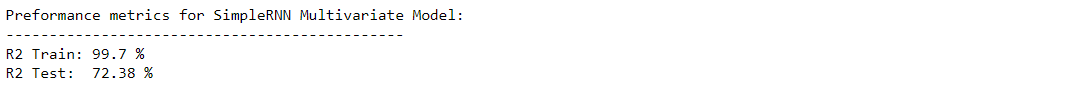
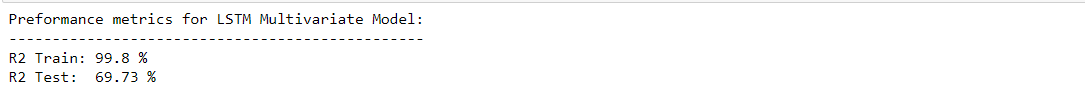
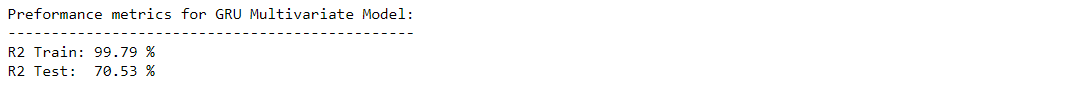


---    
####
## CONCLUSION: 
I experimented with multiple architectures, with different RNN layers, and different time steps. 
Here I'm using the same architecture but for different RNN models and different time steps: 1, 3, and 7 days.
The best model performance was achieved for the models with a time step of 1 and 7 days.     
As expected **multivariate model performed better than the univariate one**.



**Note:**      
I'm using batch_size = 1, because it gave me the best model performance. First I used more complex architecture for the model, trying to get the best model performance in order to predict Google Stock Price for real :-). This probably made the model more sensitive to batch size parameter, so the result varied a lot depending on this parameter. Then I changed it into a smaller architecture, so the result became less dependent on batch size.

---